In [118]:
# imports
import pandas as pd
import StringIO
import zipfile
import requests
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import json
%matplotlib inline

In [119]:
# read in dataframe
df_bikes = pd.read_csv('C:/Users/Michael/projects/capitalbikeshare/CombinedBikeData.csv',index_col = 0)

In [120]:
# sample data
df_bikes.head()

,Duration(h:m:s),Duration(seconds),Start_date,Start_station,End_date,End_station,Subscription_type,Bike_number,nbbikes,nbemptydocks,totaldocks,temporary,datasource,Start_day,Start_hour
0,0:22:18,1338,6/1/2015 0:00,MacDougal St & Prince St,6/1/2015 0:22,W 45 St & 8 Ave,Subscriber,20721,26,4,30,False,citibike,1,0
1,0:04:50,290,6/1/2015 0:00,St Marks Pl & 1 Ave,6/1/2015 0:05,Allen St & E Houston St,Subscriber,21606,1,26,27,False,citibike,1,0
2,0:10:34,634,6/1/2015 0:01,Greenwich Ave & Charles St,6/1/2015 0:11,W 26 St & 10 Ave,Subscriber,16595,10,28,39,False,citibike,1,0
3,0:02:39,159,6/1/2015 0:01,Allen St & Hester St,6/1/2015 0:04,Forsyth St & Broome St,Subscriber,16949,2,41,43,False,citibike,1,0
4,0:20:33,1233,6/1/2015 0:02,University Pl & E 14 St,6/1/2015 0:22,S 5 Pl & S 4 St,Customer,17028,23,11,36,False,citibike,1,0


In [121]:
# how many rides were taken in June?
df_bikes.groupby('datasource')['Duration(seconds)'].count()
# citi bike served almost 3x as many rides in June

datasource
capitalbikeshare    311692
citibike            915072
Name: Duration(seconds), dtype: int64

In [122]:
# how many stations are there?
df_bikes.groupby('datasource')['Start_station'].nunique()
# capital bikeshare has more stations

datasource
capitalbikeshare    349
citibike            312
Name: Start_station, dtype: int64

In [123]:
# how long is the median ride?
df_bikes.groupby('datasource')['Duration(seconds)'].median()
# capital bikeshare has slightly longer median rides.
# both have medians near 11 minutes

datasource
capitalbikeshare    684
citibike            645
Name: Duration(seconds), dtype: float64

In [124]:
# how long is the longest ride?
df_bikes.groupby('datasource')['Duration(seconds)'].max()
# capital bikeshare had a ride of 86k seconds (aka just under one day)
# citibike had a ride of ~19 days
# let's look at this
df_bikes[df_bikes['Duration(seconds)'] == df_bikes['Duration(seconds)'].max()]

,Duration(h:m:s),Duration(seconds),Start_date,Start_station,End_date,End_station,Subscription_type,Bike_number,nbbikes,nbemptydocks,totaldocks,temporary,datasource,Start_day,Start_hour
260582,"19 days, 13:57:53",1691873,6/10/2015 13:09,11 Ave & W 59 St,6/30/2015 3:07,Broadway & W 41 St,Customer,20700,0,35,36,False,citibike,10,13


In [125]:
# let's look at subscription type
df_bikes.Subscription_type = df_bikes.Subscription_type.map({'Subscriber':'Member','Member':'Member','Customer':'Casual','Casual':'Casual'})
df_bikes.groupby('datasource').Subscription_type.value_counts()
# ~20% of rides for capitalbikeshare are from casual members
# ~13% of rides for citibike are from casual members

datasource              
capitalbikeshare  Member    244017
                  Casual     67675
citibike          Member    788394
                  Casual    126678
dtype: int64

In [126]:
# how many bikes are there in each system?
df_bikes.groupby('datasource')['Bike_number'].nunique()
# capital bikeshare has ~3x fewer bikes that citibike

datasource
capitalbikeshare     3196
citibike            10735
Name: Bike_number, dtype: int64

In [127]:
# what is the average number of total stations? available stations?
df_stat = df_bikes.groupby(['datasource','Start_station'])['totaldocks'].mean().reset_index()
print df_stat.groupby('datasource')['totaldocks'].mean()
print
# citibike has on average double the number of terminals that capital bikeshare has

# available stations
df_stat2 = df_bikes.groupby(['datasource','Start_station'])['nbemptydocks'].mean().reset_index()
print df_stat2.groupby('datasource')['nbemptydocks'].mean()
# citibike has more than double the number of empty docks on average

datasource
capitalbikeshare    16.100287
citibike            34.814103
Name: totaldocks, dtype: float64

datasource
capitalbikeshare     8.613181
citibike            21.605769
Name: nbemptydocks, dtype: float64


    datasource                      Start_station  totaldocks
375   citibike      Atlantic Ave & Fort Greene Pl          62
568   citibike              Pershing Square North          61
469   citibike                    E 33 St & 2 Ave          59
452   citibike                 E 17 St & Broadway          59
402   citibike                 Broadway & W 55 St          59
569   citibike              Pershing Square South          59
510   citibike  Grand Army Plaza & Central Park S          59
626   citibike                    W 41 St & 8 Ave          59
365   citibike                    8 Ave & W 33 St          59
629   citibike                    W 43 St & 6 Ave          57
401   citibike                 Broadway & W 53 St          57
395   citibike                 Broadway & W 36 St          57
396   citibike                 Broadway & W 37 St          57
480   citibike                 E 47 St & Park Ave          55
642   citibike                   W 59 St & 10 Ave          55
533   ci

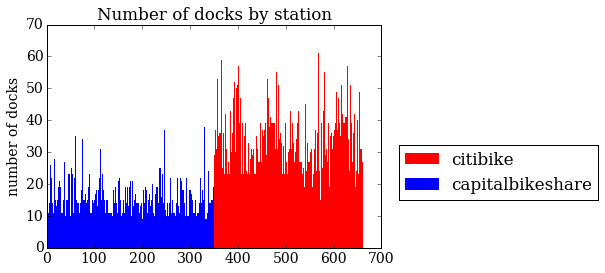

In [128]:
# let's look at the largest stations
print df_bikes.groupby(['datasource','Start_station'])['totaldocks'].mean().reset_index().sort('totaldocks',ascending=False).head(20)
print
print df_bikes.groupby(['datasource'])['Start_station'].nunique()
print
# the 20 largest stations are in citibike
df_docks = df_bikes.groupby(['datasource','Start_station'])['totaldocks'].mean().reset_index().sort('totaldocks',ascending=False)
df_docks['totaldocks'] = df_docks['totaldocks'].astype('int')
df_docks['Start_station'] = df_docks['Start_station'].apply(str)
df_docks['colors'] = df_docks['datasource'].map({'citibike':'r','capitalbikeshare':'b'})
print df_docks.dtypes
print
df_docks_citi = df_docks[df_docks.datasource == 'citibike']
df_docks_cap = df_docks[df_docks.datasource == 'capitalbikeshare']

plt.rcParams.update({'font.size':14, 'font.family':'serif'})
fig, ax = plt.subplots()
ax.bar(df_docks_citi.index.values,df_docks_citi['totaldocks'], width = 1, color = 'r', label = 'citibike', edgecolor='none')
ax.bar(df_docks_cap.index.values,df_docks_cap['totaldocks'], width = 1, color = 'b', label = 'capitalbikeshare', edgecolor='none')
ax.legend(loc = 'upper center', bbox_to_anchor=(1.35, 0.5))
ax.set_xlabel('')
ax.set_ylabel('number of docks')
ax.set_title('Number of docks by station')

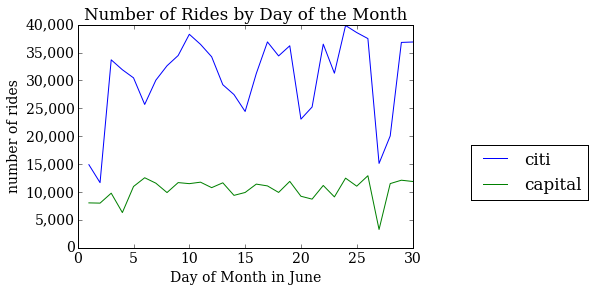

In [129]:
# let's look at number of rides by day of the month
df_start = df_bikes.groupby(['datasource','Start_day'])['Start_date'].count().reset_index()
# break into two dataframes
df_start_citi = df_start[df_start['datasource'] == 'citibike'].reset_index()
df_start_cap = df_start[df_start['datasource'] == 'capitalbikeshare'].reset_index()
# plot absolute counts
fig, ax = plt.subplots()
ax.plot(df_start_citi['Start_day'],df_start_citi['Start_date'], label = 'citi')
ax.plot(df_start_cap['Start_day'],df_start_cap['Start_date'], label = 'capital')
ax.set_ylabel('number of rides')
ax.set_xlabel('Day of Month in June')
ax.legend(loc = 'upper center', bbox_to_anchor=(1.35, 0.5))
ax.set_title('Number of Rides by Day of the Month')

# add commas to y-axis
import matplotlib.ticker as tkr
def func(x, pos):  # formatter function takes tick label and tick position
   s = '{:0,d}'.format(int(x))
   return s
y_format = tkr.FuncFormatter(func)  # make formatter
ax.yaxis.set_major_formatter(y_format)  # set formatter to needed axis

# there was a large drop on Saturday June 27th, 2015. There was 1.12 inches of rain.
# rain appears to be the biggest driver of shifts in popularity

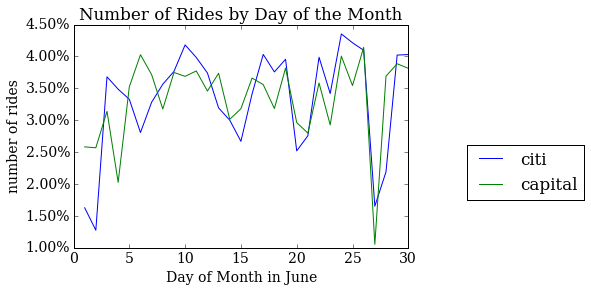

In [130]:
# let's look at rides by day, by percentage of total
df_start_citi['percentOfTotal'] = df_start_citi['Start_date']/float(df_start_citi['Start_date'].sum())
df_start_cap['percentOfTotal'] = df_start_cap['Start_date']/float(df_start_cap['Start_date'].sum())

# create plot
fig, ax = plt.subplots()
ax.plot(df_start_citi['Start_day'],df_start_citi['percentOfTotal'], label = 'citi')
ax.plot(df_start_cap['Start_day'],df_start_cap['percentOfTotal'], label = 'capital')
ax.set_ylabel('number of rides')
ax.set_xlabel('Day of Month in June')
ax.legend(loc = 'upper center', bbox_to_anchor=(1.35, 0.5))
ax.set_title('Number of Rides by Day of the Month')

# format y-axis
def func(x, pos):  # formatter function takes tick label and tick position
   s = '{:1.2f}%'.format(x*100)
   return s
y_format = tkr.FuncFormatter(func)  # make formatter
ax.yaxis.set_major_formatter(y_format)  # set formatter to needed axis

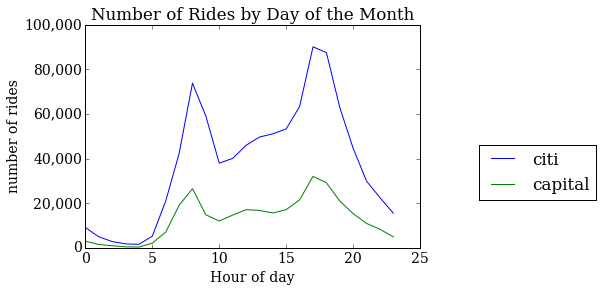

In [133]:
# now let's check out the most popular hours to rent a bike
df_hour = df_bikes.groupby(['datasource','Start_hour'])['Start_date'].count().reset_index()

# break into two dataframes
df_hour_citi = df_hour[df_hour['datasource'] == 'citibike'].reset_index()
df_hour_cap = df_hour[df_hour['datasource'] == 'capitalbikeshare'].reset_index()

# plot absolute counts
fig, ax = plt.subplots()
ax.plot(df_hour_citi['Start_hour'],df_hour_citi['Start_date'], label = 'citi')
ax.plot(df_hour_cap['Start_hour'],df_hour_cap['Start_date'], label = 'capital')
ax.set_ylabel('number of rides')
ax.set_xlabel('Hour of day')
ax.legend(loc = 'upper center', bbox_to_anchor=(1.35, 0.5))
ax.set_title('Number of Rides by Day of the Month')

# add commas to y-axis
import matplotlib.ticker as tkr
def func(x, pos):  # formatter function takes tick label and tick position
   s = '{:0,d}'.format(int(x))
   return s
y_format = tkr.FuncFormatter(func)  # make formatter
ax.yaxis.set_major_formatter(y_format)  # set formatter to needed axis


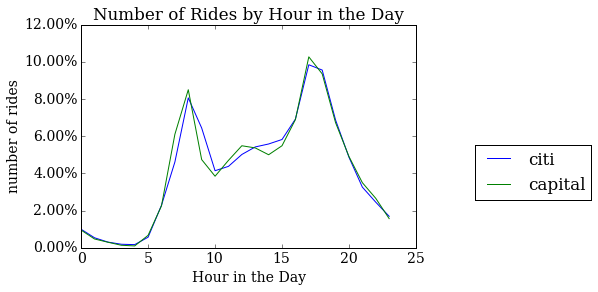

In [136]:
# let's look at rides by hour, as a percentage of total
df_hour_citi['percentOfTotal'] = df_hour_citi['Start_date']/float(df_hour_citi['Start_date'].sum())
df_hour_cap['percentOfTotal'] = df_hour_cap['Start_date']/float(df_hour_cap['Start_date'].sum())

# create plot
fig, ax = plt.subplots()
ax.plot(df_hour_citi['Start_hour'],df_hour_citi['percentOfTotal'], label = 'citi')
ax.plot(df_hour_cap['Start_hour'],df_hour_cap['percentOfTotal'], label = 'capital')
ax.set_ylabel('number of rides')
ax.set_xlabel('Hour in the Day')
ax.legend(loc = 'upper center', bbox_to_anchor=(1.35, 0.5))
ax.set_title('Number of Rides by Hour in the Day')

# format y-axis
def func(x, pos):  # formatter function takes tick label and tick position
   s = '{:1.2f}%'.format(x*100)
   return s
y_format = tkr.FuncFormatter(func)  # make formatter
ax.yaxis.set_major_formatter(y_format)  # set formatter to needed axis